In [1]:
#|default_exp resnet

# ResNets

The model that we've been using for a while it's a convolution, an activation and an optional batchNorm.
In our models we were using `batchNorm2d` and applying Ximing weight initialization.
Then convs that take the channels from 1 to 8 to 16 to 32 to 64,
and each one stride-2 and at the end a flatten, so we ended up with a 1x1.
That's been the model we've been using for a while.
The number of layers is 4 convolutional layers (1-8, 8-16, 16-32, 32-64),
with a maximum of 64 channels in the last one.
Can we beat our last accuracy?

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

Before we do a resnet, let's try to improve the architecture thoughtfully.
Generally more depth and more channels gives the neural net more opportunity to learn.
Since we're good at initializing our neural Nets and using batchNorm we should be able to do deeper.

Lets review the previous version so we can compare. 

In [7]:
get_model??

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      ~/GitHub/course22p2/nbs/miniai/init.py
Type:      function


If we the first convolutional layer have a stride-1, 
it would go from 1 input channel to 8 output channels (filters):<br>
`layers = [conv(1, 8, stride=1, act=act, norm=norm)]`
That allows us to have one extra layer, which can double the number of filters to 128,
`nfs=(8,16,32,64,128)` making it a deeper and wider.

## Going deeper

In [8]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

We can do a normal `BatchNorm2D` and `OneCircleLR` with our scheduler `sched`.
For the callbacks `cbs` we use the `DeviceCB` `metrics` `ProgressCB` and our activation stats `astats`
looking for `GeneralRelu`.

In [9]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

With this deeper and eventually wider Network we get .92 accuracy,
a big improvement with the only difference to our previous model is line of code :
`layers = [conv(1, 8, stride=1, act=act, norm=norm)]`
which allowed us to go `nfs=(8,16,32,64,128)`.
A small change but  the error rates gone down by over 10 percent.

accuracy,loss,epoch,train
0.810,0.693,0,train
0.815,0.584,0,eval
0.882,0.343,1,train
0.888,0.320,1,eval
0.903,0.271,2,train
0.879,0.331,2,eval
0.920,0.223,3,train
0.910,0.257,3,eval
0.939,0.178,4,train
0.917,0.234,4,eval


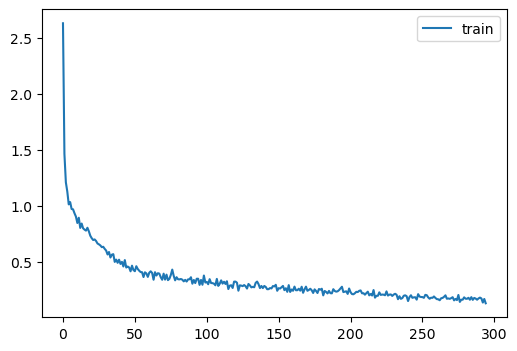

In [10]:
learn.fit(epochs)

## Skip Connections

We want to make it deeper. 
But there comes a point where making an ANN deeper stops working well.
Even with good initialization there comes a time where adding more layers becomes problematic.
Kaiming He pointed out something particularly interesting in "Deep residual learning for image recognition". 
Let's take a 20 layer ANN and train it for tens of thousands of iterations and track its test error.
Then let's do the same thing on an identical but deeper 56 layer Network.
The 56 layer Network had a worse error than the 20 layer.
It wasn't just a problem of generalizations it was worse on the training set too.
The Insight is that if we set the additional 36 layers to just identity matrices they would do nothing at all.
A 56 layer network is a superset of a 20 layer Network, so it should be at least as good.
But it is worse, so clearly the problem is something about training it.
Insight: create a 56 layer Network which has the same training dynamics as a 20 layer Network or even less.
They realized we could add a "shortcut connection".

The ResNet (*residual network*) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a *skip connection* to allow deeper networks to train successfully.

<img width="700" src="images/att_00042.png">

When we have inputs coming into a convolution, 
if we do this 56 times that's a lot of stacked up convolutions, 
which are Matrix multiplications with a lot of opportunity for gradient explosions and all that fun.
How can we have as many convolutions but with the training dynamics of a much shallower Network?
Let's put two convs to make it twice as deep.
Let's add a skip connection, such that:
`out = conv2(conv1(in)) + in` 
(assume that these include activation functions)

If we initialize `conv2` and `conv1` first to have weights of zero,
then `out` equals `in`, which is what we wanted, i.e., if there is no extra layers.
This way we end up with a network which can be deep but at least when we start
training behaves as if it's shallow.
This is called a <mark> residual connection </mark>,
because if we subtract `in` from both sides, we get `out - in = conv2(conv1(in))`.
The difference (`out-in`) between the end point and the starting point which is the <mark>residual</mark>.
<br>
This only works if we can add these together.
If `conv1` and `conv2` both have the same number of filters and also have stride-1, then that will work fine.
We end up with the same output shape as the input shape and you can add them together.
But if they are not the same shape, then we are in trouble.
The answer is to add an "identity" `conv(in)`, which is not really an identity,  
but we are trying to make it as simple as possible.
The simplest possible convolution is a 1x1 kernel block.
Using that we can also add a stride or whatever if we want.


Lets create a `_conv_block`, which does the 2 convs, with `ni` number of input filters,
`nf` number of output filters, `stride`, `act` activation function,
possibly a normalization `norm` and a kernel size `ks`.
The second conv `conv2` is going from output filters `nf` to output filters `nf`,
as the first conv is going to be from `ni` to `nf`:
`conv(ni, nf, stride=1, act=act, norm=norm, ks=ks`
The first conv we set `stride=1` and the second conv will have the requested `stride`.
That way the two convs back to back overall have the requested stride.
The combination of these two convs takes us from `ni` to `nf`, and it's going to have the `stride` that we requested.

In [11]:
#|export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    conv2 = conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks)
    if norm: init.constant_(conv2[1].weight, 0.)
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks), conv2)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

A `_conv_block` is a `Sequential` block, consisting of a convolution followed by another convolution.
Each `conv` has the requested: kernel size `ks`, activation function `act`, and normalization layer `norm`.
But the second conv,`conv2` won't have an activation function. (why?).
One way to make this as if it didn't exist would be to set the convolutional weights and biases to 0.
But we would prefer to have correctly randomly initialized weights.

If we're using `batchNorm` (`if norm:`) we can initialize `conv2[1].weight`, 
the `batchNorm` weights to 0. (See implementation from scratch of batchNorm).
Because the `batchNorm.weight` is the thing we multiply by.
In `BatchNorm` we subtract the exponential moving average mean, 
we divide by the exponential moving average standard deviation, 
and then multiply by weights and add back the bias layer. 
If we set the batchNorm layers weights to 0, we're multiplying by 0,
and the initial `_conv_block` output will be all zeros.
That is what we wanted, as we end up with just the input.

A `ResBlock` contains those convolutions in the `_conv_block`.
Then we need the `idconv`, which is going to be a `fc.noop`, (nothing)
if the number of channels in `ni` is equal to the number of channels out `nf`.
Otherwise, we use a convolution with `ks=1, stride=1`, which changes the number of filters so that they match.

What if the stride is not 1?
If the stride is 2, (will only work for 2?), 
we average using `nn.AvgPool2d` (i.e., take the mean of every set of two items in the grid.
That is pool of idcon of n if the stride is 2 and the filter number is changed.
And that's the minimal amount of work.

In `forward` we get the input `x`.
On the identity connection `idconv` we call `pool(x)` and if `stride==1` that's a noop.
We do `idconv` and if `ni==nf` (number of filters has not changed), that's also a noop.
So `self.idconv` is just the input (in that situation).
We add that to the result of the convs (and here's something interesting) 
we then apply the activation function `.act` to the result of the whole resnet block.
(This is the reason we did not earlier add the `act` to the `conv2`)

We copied the `get_model` and replaced what previously had a `conv` by a `ResBlock`.
Previously we started with `conv(1,8, ...)`, now we have  `ResBlock(1,8, ....)`
Then we added `conv(nfs[i], nfs[i+1], ...)`, now we have `ResBlock(nfs[i], nfs[i+1], ...)`,
so it's (exactly?) the same (stride=2 added?).
One change is that previously the very last `conv` at the end went from 128 filters down to 10 followed by `flatten`.
But this `conv` is working on a 1x1 input, so an alternate way is flatten first and then use a linear layer.
Because a `conv` on a 1x1 input is identical to a linear layer.
<mark> TODO: Think about why a `conv` on a 1x1 is the same.  Look at the `conv` from scratch we did.</mark>

In [12]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

This is an important insight so it's very useful with a more complex model like this to take a good
look at it to see exactly what the inputs and outputs of each layer are.
`print_shape` takes the things that a `hook` takes.
We will print out for each layer the name of the class, the shape of the input and the shape of the output.
We can get our `model` create our learner `learn`, and use our `Hawks` context manager 
to call the `_print_shape` function.
Then we will call `fit` for one epoch just doing the evaluation. 

In [13]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


If we use the `SingleBatchCB` it will do a single batch, pass it the hook 
and print out each layer, the inputs shape and the output shape.
We're starting with an input of a batch size of 1024, 1 Channel, 28 by 28.
Our first `ResBlock` was stride-1 so we end up with 28 by 28, with 8 filters.
Then we gradually decrease the grid size to 14x14, 7x7, 4x4, 2x2 to 1x1,
while we gradually increase the number of filters up to 256.
We then flatten it which gets rid of that 1x1 and allows us then to do `Linear`, to count over the 10.
And then (JH found it useful in this case) so we've got a BatchNorm1d at the end.

We create a `@fc.patch` for `Learner.summary` that would do the same thing as a markdown table.
If we create a Learner with our model, the `.summary` method is now available 
because it's been patched into the Learner.
It does the same thing as `_print_shape` but using a markdown table 
if it's in a notebook, otherwise it'll just print it.
(*fastcore* has `fc.IN_NOTEBOOK` to find out if we're in a notebook.
In a notebook we use `Markdown` from `Ipython.display`.
Also added the number of parameters, `nparms`, calculated by summing up the number 
of elements for each parameter in that module (`mod.parameters`).
At the end we also print out the total number of parameters, `tot`.
Here we've got a 1.2 million parameter model.

In [14]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

There are few parameters in the input, nearly all parameters are in the last `ResBlock` layer.
Why? 
For every input Channel we have a set of parameters, they're all going to get added up 
across each of the 3x3 in the kernel.
And then that's going to be done for every output filter.

In [15]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1226892


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|680|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3632|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14432|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57536|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|229760|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|918272|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


We call `LRfind` and get a sense of what kind of `lr` to use, e.g., `2e-2`.

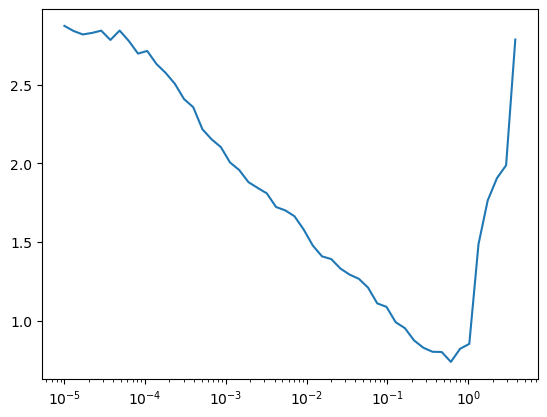

In [16]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [17]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.780,0.796,0,train
0.819,0.538,0,eval
0.874,0.399,1,train
0.839,0.458,1,eval
0.901,0.296,2,train
0.904,0.283,2,eval
0.922,0.228,3,train
0.912,0.261,3,eval
0.942,0.175,4,train
0.923,0.231,4,eval


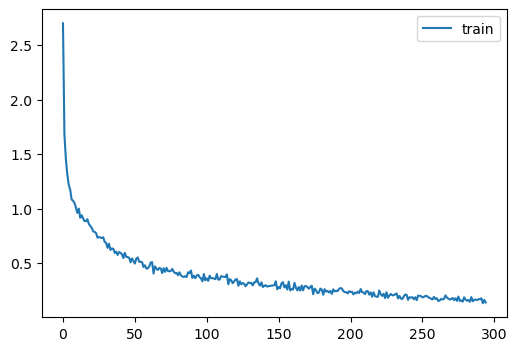

In [18]:
learn.fit(epochs)

Using Resnet we've gone up from .917 to .922 in five epochs.
And this resnet is the simplest `Resblock`. 
We just replaced each `conv` with `ResBlock`.

In [19]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

We can try other ResNets by grabbing `timm` (Ross Whiteman's Pytorch image model Library).
If we call `timm.list_models('resnet*')` there are a lot of resnets.
JH tried a few of them.
In the source code for *timm* you'll see that the various different
resnets, like `resnet18`, `resnet18D`,  `resnet10t`, etc. 

In [20]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight ens_adv_inception_resnet_v2 gcresnet33ts gcresnet50t gluon_resnet18_v1b gluon_resnet34_v1b gluon_resnet50_v1b gluon_resnet50_v1c gluon_resnet50_v1d gluon_resnet50_v1s gluon_resnet101_v1b gluon_resnet101_v1c gluon_resnet101_v1d gluon_resnet101_v1s gluon_resnet152_v1b gluon_resnet152_v1c gluon_resnet152_v1d gluon_resnet152_v1s inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50d resnet50t resnet51q resnet61q resnet101 resnet101d resnet152 resne

```
resnet18:  block=BasicBlock, layers=[2, 2, 2, 2]
resnet18d: block=BasicBlock, layers=[2, 2, 2, 2], stem_width=32, stem_type='deep', avg_down=True
resnet10t: block=BasicBlock, layers=[1, 1, 1, 1], stem_width=32, stem_type='deep_tiered', avg_down=True
```

They're defined in a very elegant configuration, so we can see what's different.
Basically one line of code different between each different type of resnet for the main resnets.
JH tried all the 10 models.
Also tried importing the underlying pieces and building ResNets with them.
The best was `resnet18d`. 

In [21]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)
# model = ResNet(in_chans=1, block=BasicBlock, layers=[2,2,2,2], stem_width=32, avg_down=True)

In [22]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training it in exactly the same way JH got to .92, (we got .924) less than our .922.
A thoughtfully designed basic architecture goes a very long way.
It shows that we can create a state-of-the-art architecture by using common sense.

accuracy,loss,epoch,train
0.771,0.657,0,train
0.744,1.228,0,eval
0.877,0.332,1,train
0.879,0.343,1,eval
0.906,0.251,2,train
0.900,0.269,2,eval
0.928,0.194,3,train
0.917,0.225,3,eval
0.946,0.147,4,train
0.924,0.220,4,eval


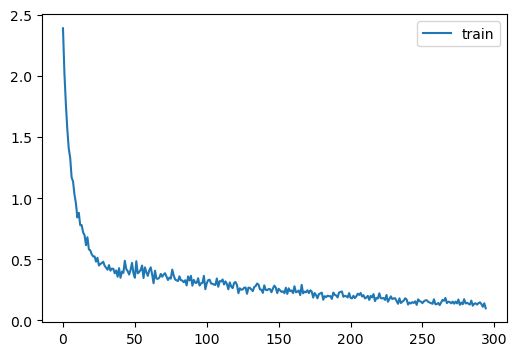

In [23]:
learn.fit(epochs)

## Export -

In [24]:
import nbdev; nbdev.nbdev_export()